# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
sys.path.insert(0, os.environ.get('SRC_FIGMA_PATH'))


from cryptocurrencyetl import CryptocurrencyEtl
import context as c
from dataanalysis import DataAnalysis

# 1.0. Data Extraction

In [2]:
crypto = 'BTC'
market_curr = 'USD'
api_key = os.environ.get('TOKEN_FIGMA_CRYPTO_KEY')

crypt_etl = CryptocurrencyEtl(crypto=crypto, market_curr=market_curr, api_key=api_key)

#crypt_etl.test_market_curr()
#crypt_etl.test_crypto()

df_btc_usd = crypt_etl.run()

2022-06-13 20:41:52,521 (INFO)	||| Initing extract of ETL to obtain BTC historical data in USD value!
2022-06-13 20:41:54,069 (INFO)	||| Initing data transform of BTC historical data!
2022-06-13 20:41:54,085 (INFO)	||| ETL finished!


# 2.0. Data Analysis

In [3]:
analy = DataAnalysis(df_btc_usd)

In [4]:
check_index_dtype = pd.DataFrame(df_btc_usd.index).select_dtypes('datetime64[ns]')
check_index_dtype.shape[1]

1

## 2.1. Statistical Description

In [5]:
analy.statistical_description()

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,open,28525.823120,30306.575000,18655.290383,4800.010000,67525.820000,62725.810000,0.241594,-1.417800
1,high,29322.798110,31394.450000,19174.535113,5365.420000,69000.000000,63634.580000,0.229149,-1.437062
2,low,27617.185600,29288.285000,18044.737205,3782.130000,66222.400000,62440.270000,0.254727,-1.396934
3,close,28542.615380,30306.585000,18646.464970,4800.000000,67525.830000,62725.830000,0.240217,-1.416561
4,volume,64549.530025,55341.317023,37636.772840,6865.239989,402201.673764,395336.433775,2.627800,12.862362


## 2.2. Temporal Estability

### 2.2.1. Year

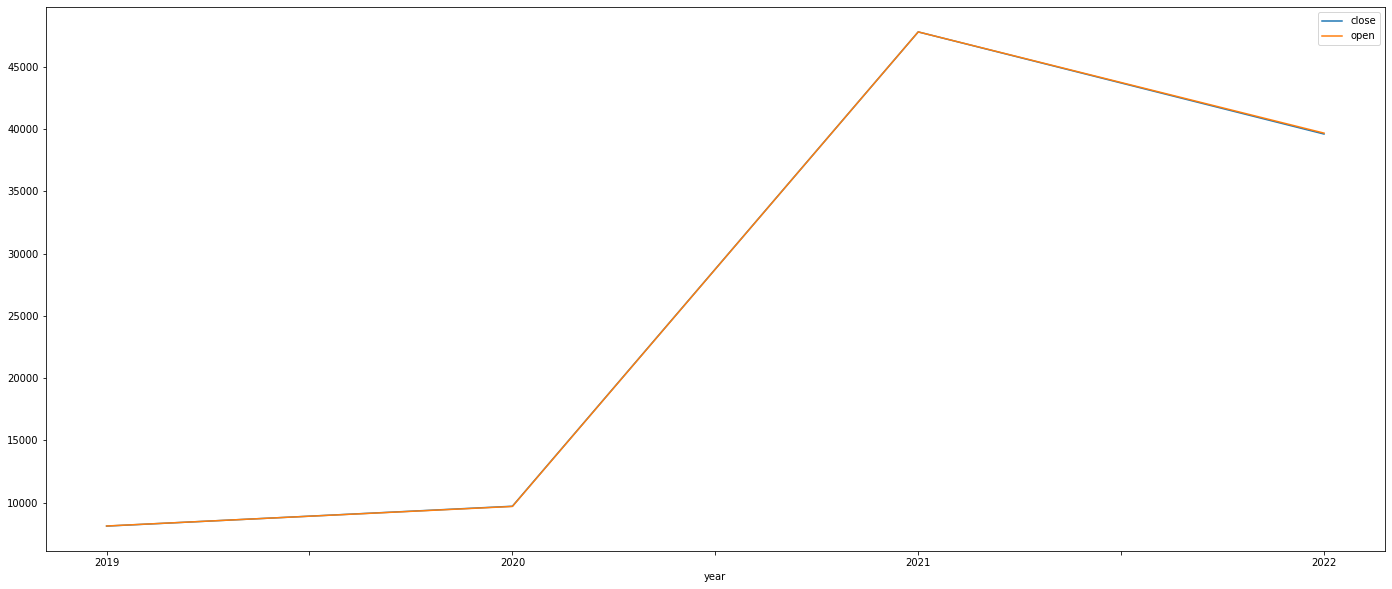

In [6]:
analy.annual_stability(y=['close', 'open'], figsize=(24, 10))

### 2.2.2. Monthly

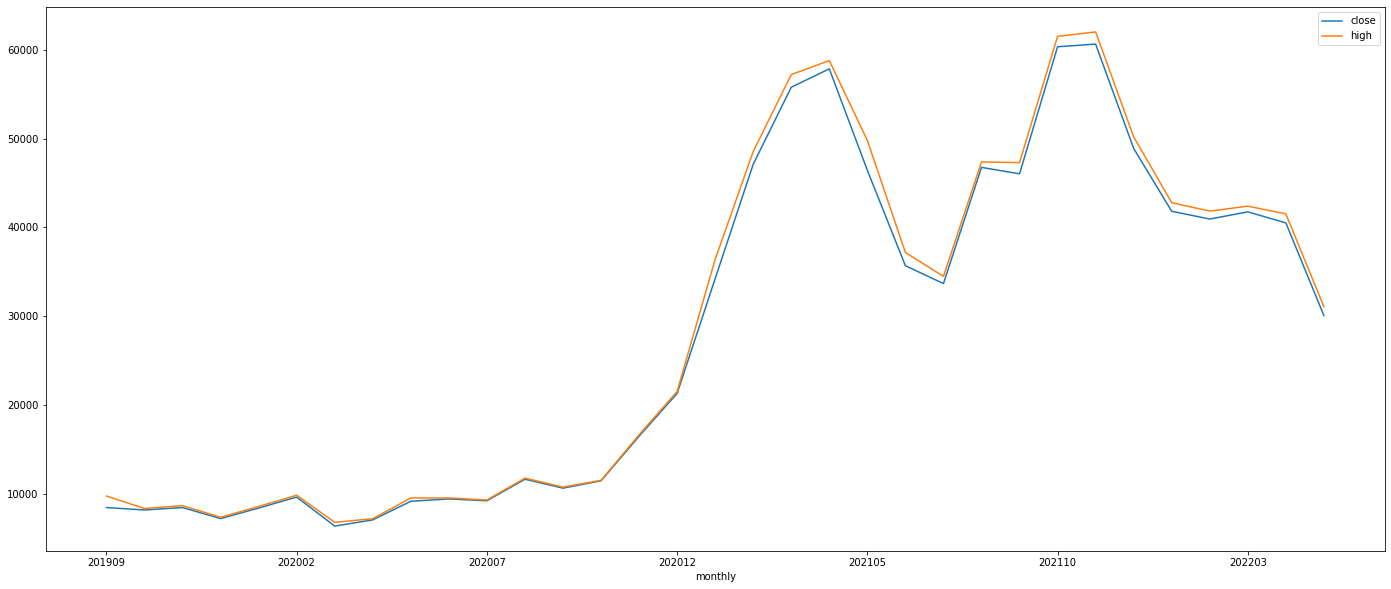

In [7]:
analy.monthly_stability(y=['close', 'high'], figsize=(24, 10))

### 2.2.3. Daily

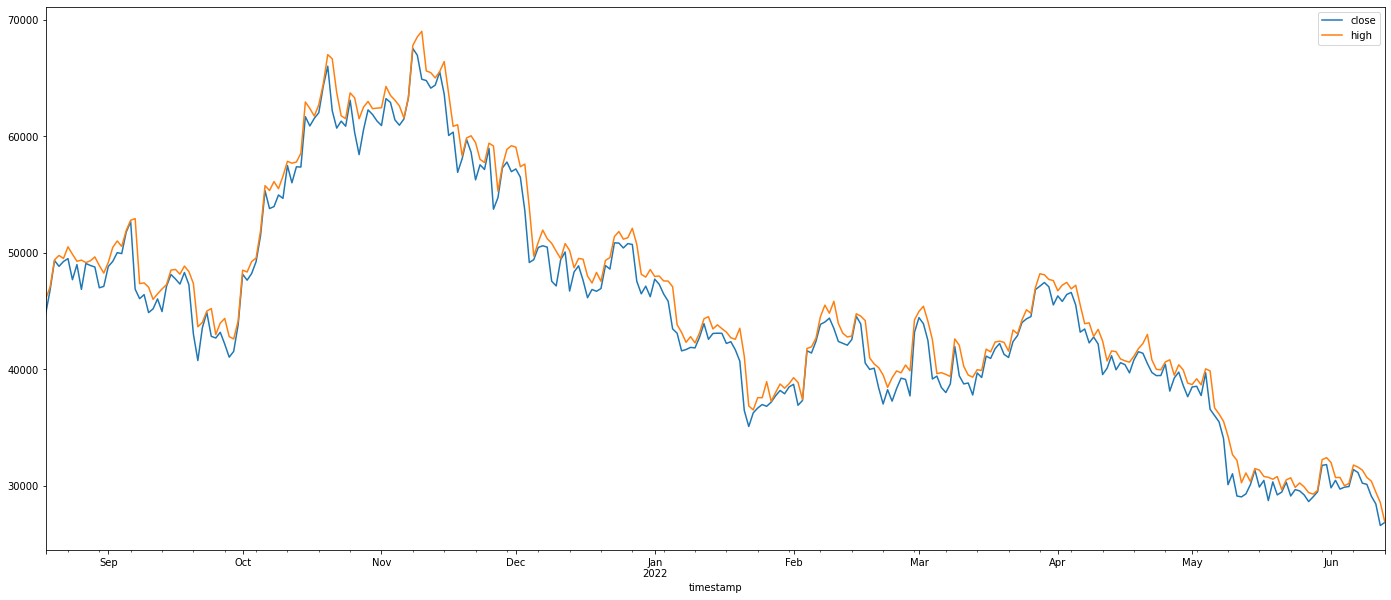

In [15]:
analy.daily_stability(last_days=300, y=['close', 'high'], figsize=(24, 10))

## 2.3. Outlier Identification

## 2.4. Distribution

## 2.5. Nature Transformation Effect

# 3.0. Data Preparation

## 3.1. Adjust Dataset

## 3.2. Nature Transformation

# 4.0. Machine Learning Model

## 4.1. SARIMAX

### 4.1.1. Modeling

### 4.1.2. Validation

## 4.2. ARIMA

### 4.2.1. Modeling

### 4.2.2. Validation

## 4.3. Saving Model